In [ ]:
import tensorflow as tf


In [ ]:
import os
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68606236/68606236 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [ ]:
valdation_batches = tf.data.experimental.cardinality(validation_dataset)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
test_batches = valdation_batches // 5
test_dataset = validation_dataset.take(test_batches)
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
validation_dataset = validation_dataset.skip(test_batches)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Number of validation batches: 32
Number of test batches: 6
Number of validation batches: 26


In [ ]:
class_names = train_dataset.class_names
class_names

['cats', 'dogs']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

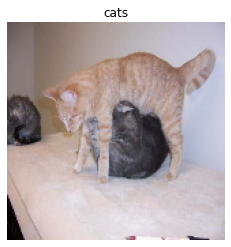

In [ ]:
for image, label in train_dataset.take(1):
    image = image.numpy().astype("uint8")
    plt.imshow(image[0])
    plt.title(class_names[label[0]])
    plt.axis('off')
    plt.show()

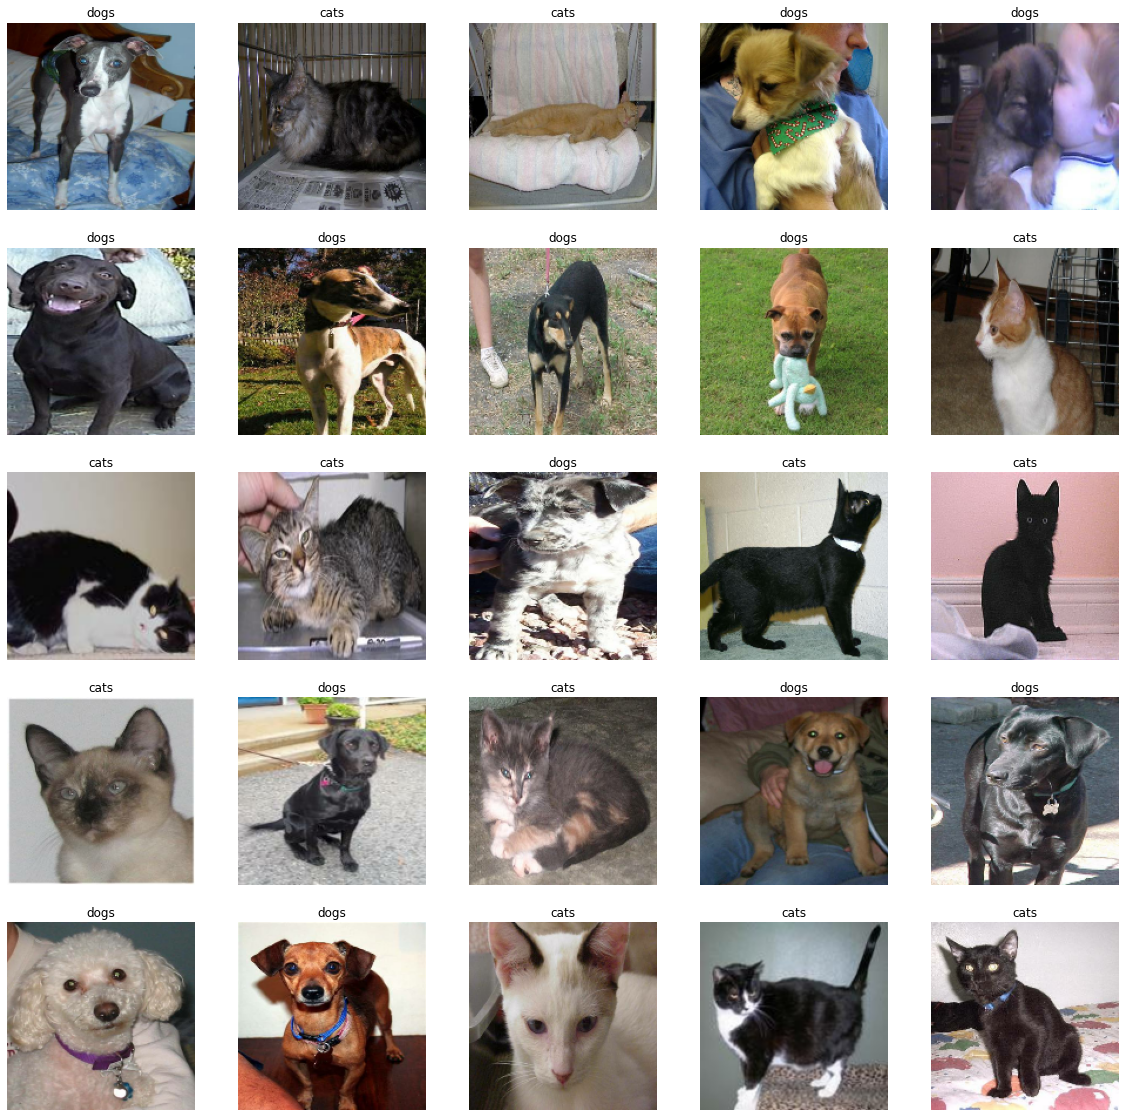

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in train_dataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

first image shape: (160, 160, 3)
Expaned dims of first image:   (1, 160, 160, 3)


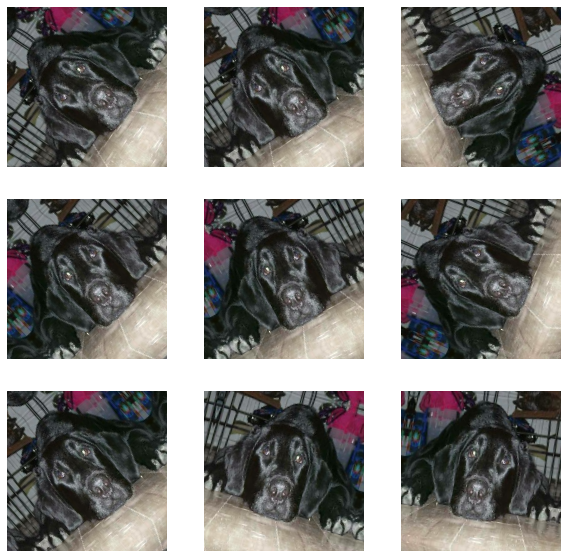

In [ ]:
data_augmentation = tf.keras.Sequential([
tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

plt.figure(figsize=(10, 10))
for image, label in train_dataset.take(1):
    first_image = image[0]
    print(f'first image shape: {first_image.shape}')
    expaned_dims_first_image =  tf.expand_dims(first_image, 0)
    print(f'Expaned dims of first image:   {expaned_dims_first_image.shape}')
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        augmented_image=data_augmentation(expaned_dims_first_image)
        
        #rescale augmented_image
        augmented_image = augmented_image[0] / 255
        plt.imshow(augmented_image)
        plt.axis('off')

In [ ]:
IMG_SIZE
IMG_SHAPE = IMG_SIZE + (3,)
IMG_SHAPE

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

9406464/9406464 [==============================] - 0s 0us/step
(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model

(32, 1)


In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281  

In [ ]:
len(model.trainable_variables)
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
EPOCHS = 10
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset)

26/26 [==============================] - 18s 579ms/step - loss: 0.8006 - accuracy: 0.5149
initial loss: 0.80
initial accuracy: 0.51
Epoch 1/10


63/63 [==============================] - 67s 947ms/step - loss: 0.7247 - accuracy: 0.5710 - val_loss: 0.5955 - val_accuracy: 0.6720
Epoch 2/10
63/63 [==============================] - 62s 988ms/step - loss: 0.6322 - accuracy: 0.6380 - val_loss: 0.5642 - val_accuracy: 0.7401
Epoch 3/10
63/63 [==============================] - 62s 987ms/step - loss: 0.6085 - accuracy: 0.6650 - val_loss: 0.5300 - val_accuracy: 0.7042
Epoch 4/10
63/63 [==============================] - 64s 1s/step - loss: 0.5905 - accuracy: 0.6675 - val_loss: 0.5277 - val_accuracy: 0.6980
Epoch 5/10
63/63 [==============================] - 66s 1s/step - loss: 0.5672 - accuracy: 0.6980 - val_loss: 0.5090 - val_accuracy: 0.7166
Epoch 6/10
63/63 [==============================] - 72s 1s/step - loss: 0.5748 - accuracy: 0.6845 - val_loss: 0.4904 - val_accuracy: 0.7748
Epoch 7/10
63/63 [==============================] - 66s 1s/step - loss: 0.5655 - accuracy: 0.7000 - val_loss: 0.4768 - val_accuracy: 0.7624
Epoch 8/10
63/63 [====

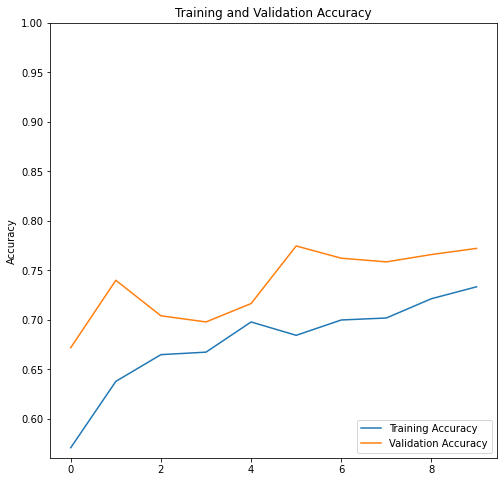

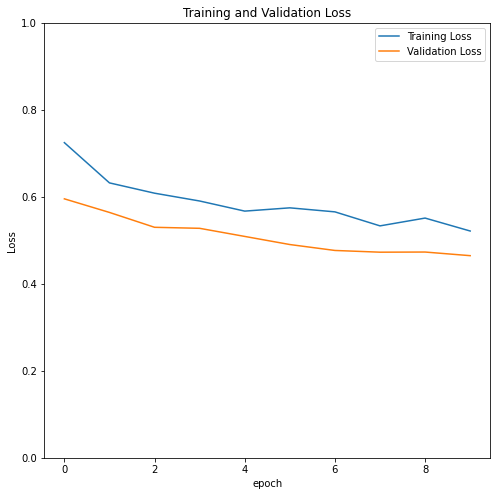

[ 1.6889393  -0.34429777 -1.9982239   0.67173725 -3.5155528   1.374198
  0.8089786   1.1799455   0.3339224   1.6831734  -0.42056626  0.03909134
  3.466325    0.56474507  1.502911    0.12902904 -0.9521275   1.2260283
  2.560272    1.0330921  -1.2084981  -0.24947199 -0.41497976 -0.13248748
 -0.78521067  0.6001884   2.1647453   3.5571945  -0.42255828 -1.6513194
  0.05923617 -0.12265157]


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.show()
plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
print(predictions)

Number of layers in the base model:  154
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)      

63/63 [==============================] - 95s 1s/step - loss: 1.1781 - accuracy: 0.4965 - val_loss: 0.6942 - val_accuracy: 0.5050
Epoch 11/20
63/63 [==============================] - 87s 1s/step - loss: 0.7488 - accuracy: 0.5050 - val_loss: 0.7148 - val_accuracy: 0.4926
Epoch 12/20
63/63 [==============================] - 93s 1s/step - loss: 0.7540 - accuracy: 0.4980 - val_loss: 0.7397 - val_accuracy: 0.4950
Epoch 13/20
63/63 [==============================] - 85s 1s/step - loss: 0.7184 - accuracy: 0.5185 - val_loss: 0.6957 - val_accuracy: 0.5012
Epoch 14/20
63/63 [==============================] - 78s 1s/step - loss: 0.7338 - accuracy: 0.4925 - val_loss: 0.6935 - val_accuracy: 0.4901
Epoch 15/20
63/63 [==============================] - 84s 1s/step - loss: 0.7161 - accuracy: 0.4920 - val_loss: 0.6933 - val_accuracy: 0.4988
Epoch 16/20
63/63 [==============================] - 86s 1s/step - loss: 0.7082 - accuracy: 0.5085 - val_loss: 0.7185 - val_accuracy: 0.4950
Epoch 17/20
63/63 [======

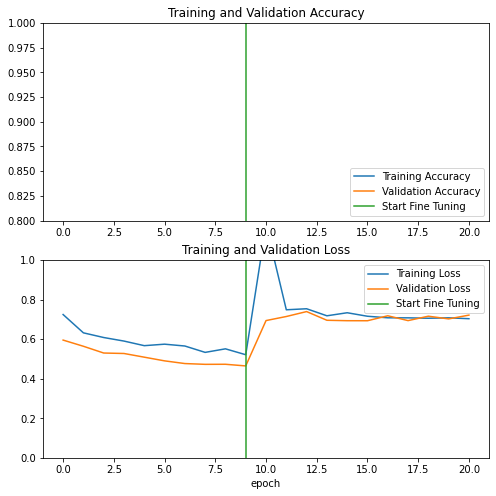

6/6 [==============================] - 4s 651ms/step - loss: 0.7304 - accuracy: 0.4948
Test loss : 0.7304213643074036
Test accuracy : 0.4947916567325592


In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 100
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()
len(model.trainable_variables)

FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS =  EPOCHS + FINE_TUNE_EPOCHS
history_fine = model.fit(train_dataset,
                         epochs=TOTAL_EPOCHS,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([EPOCHS-1,EPOCHS-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCHS-1,EPOCHS-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
loss, accuracy = model.evaluate(test_dataset)

print('Test loss :', loss)
print('Test accuracy :', accuracy)

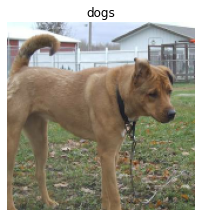

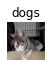

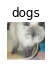

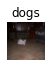

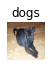

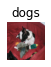

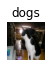

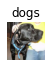

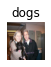

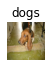

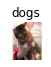

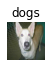

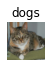

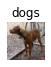

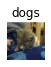

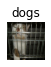

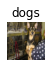

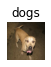

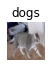

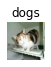

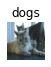

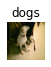

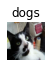

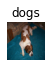

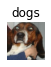

In [ ]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
print(predictions)
# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
plt.figure(figsize=(20, 20))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")
    plt.show()